# **Decision Tree Regressor**

> ### Mitul Agrawal

Drive Link : [PRML Lab 3 Drive](https://drive.google.com/drive/folders/1gYj4hHUFyzkX7nACDyfBh2U3133VeTmq?usp=sharing)

In [ ]:
from google.colab import drive
#drive.mount('/content/drive/')

path = '/content/drive/My Drive/PRML/Lab 3/'

##Decision Tree Regressor

###1) Decision Tree Regressor (from Scratch)

####Preprocessing

In [ ]:
import pandas as pd
import time

df = pd.read_csv(path+'Housing.csv')

def remove_missing(df) : 
  remove = []
  for i, row in df.iterrows():
    if row.isna().values.any() : remove.append(i)
  df.drop(remove,axis=0,inplace=True)

def remove_mismatch(df) : 
  for col in df : 
    df.reset_index(drop=True, inplace=True)
    s = [False]*len(df[col])
    for i,cell in enumerate(df[col]) : 
      try : n = int(cell)
      except : s[i] = True
    t = s.count(True)
    f = s.count(False)
    st = False
    if(t>f) : st = True
    remove = [i for i in range(len(df[col])) if s[i]!=st]
    df.drop(remove,axis=0,inplace=True)

def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

remove_missing(df)

remove_mismatch(df)

str_to_num(df)

def encode_label(df,col,order) : 
  if(order==[]) : order = list(df[col].unique())
  for i,cell in enumerate(df[col]) : 
    try : 
      df.at[i,col] = order.index(df[col][i])
    except : 
      df.at[i,col] = -1

def encode_labels(df,cols) : 
  for col in cols.keys() : 
    encode_label(df,col,cols[col])

labels = {}
labels['mainroad'] = ['no','yes']
labels['guestroom'] = ['no','yes']
labels['basement'] = ['no','yes']
labels['hotwaterheating'] = ['no','yes']
labels['airconditioning'] = ['no','yes']
labels['prefarea'] = ['no','yes']
labels['furnishingstatus'] = ['unfurnished','semi-furnished','furnished']

print("Shape Before :",df.shape)
 
encode_labels(df,labels)

str_to_num(df)


def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

normalize_dbl(df,cols=['price'])


df.head(4)

Shape Before : (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,1.000000,7420,4,2,3,1,0,0,0,1,2,1,2
1,0.921053,8960,4,4,4,1,0,0,0,1,3,0,2
2,0.921053,9960,3,2,2,1,0,1,0,0,2,1,1
3,0.918421,7500,4,2,2,1,0,1,0,1,3,1,2


In [ ]:
x = df.iloc[:,1:].copy()
y = df.iloc[:,0].copy()

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.85,random_state=42) 

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print("Train Data   :",x_train.shape)
print("Train Labels :",y_train.shape)
print()
print("Test Data    :",x_test.shape)
print("Test Labels  :",y_test.shape)

Train Data   : (463, 12)
Train Labels : (463,)

Test Data    : (82, 12)
Test Labels  : (82,)


####Cost Function

In [ ]:
def find_index(elem,arr) : 
  for i,a in enumerate(arr) : 
    if(a==elem) : return i
  return -1


def Var(A,Y,th=None) :
  if th is None : 
    unique = A.unique()
    u = len(unique)
  else : 
    u = 2
  N = A.shape[0]
  sq = Y.pow(2).sum()
  if th is None : 
    xs = [Y.loc[A==unique[i]].sum() for i in range(u)]
    n = [A[A==unique[i]].shape[0] for i in range(u)]
  else :
    xs = [Y.loc[A>=th].sum(),Y.loc[A<th].sum()]
    n = [A[A>=th].shape[0],A[A<th].shape[0]]
  Var = sq - sum([xs[i]**2/n[i] for i in range(u) if n[i]>0])
  Var = Var/N
  return Var


def Var_Gain(A,Y,th=None) :
  if th is None : 
    unique = A.unique()
    u = len(unique)
  else : 
    u = 2
  N = A.shape[0]
  if th is None : 
    xs = [Y.loc[A==unique[i]].sum() for i in range(u)]
    n = [A[A==unique[i]].shape[0] for i in range(u)]
  else :
    xs = [Y.loc[A>=th].sum(),Y.loc[A<th].sum()]
    n = [A[A>=th].shape[0],A[A<th].shape[0]]
  Gain = sum([(xs[i]**2)/n[i] for i in range(u) if n[i]>0]) - (sum(xs)**2)/N
  Gain = Gain/N
  return Gain


print(Var_Gain(x_train['area'],y_train,6000))

0.006188078168355201


####Threshold Function

In [ ]:
def find_th(A,Y) :
  N = A.shape[0] 
  sum_max = None
  th = None
  y = Y.tolist()
  a = A.tolist()
  zipped = list(zip(a,y))
  zipped.sort()
  a,y = zip(*zipped)
  a = list(a)
  y = list(y)
  x0 = y[0]
  x1 = sum(y)-x0
  n0 = 1
  n1 = N-n0
  for i in range(N-1) : 
    sum_i = x0**2/n0 + x1**2/n1
    if(a[i]!=a[i+1]) : 
      if(sum_max is None or sum_i>sum_max) : 
        sum_max = sum_i
        th = a[i+1]
    x0 = x0 + y[i+1]
    x1 = x1 - y[i+1]
    n0 = n0 + 1
    n1 = n1 - 1 
  return th

th = find_th(x_train['area'],y_train)
print(th)

5960


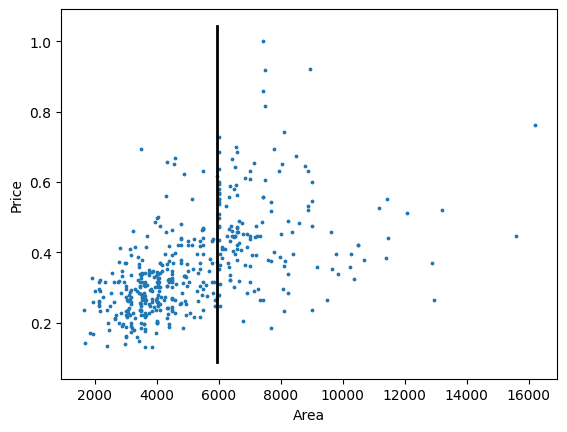

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(x_train['area'],y_train,s=3)
plt.xlabel("Area") 
plt.ylabel("Price")
plt.plot([th,th],plt.gca().get_ylim(), linewidth=2,color="black")

####Decison Tree Regressor

In [ ]:
class Node : 

  def __init__(self,dep=-1) : 
    self.child = {}
    self.A = None
    self.th = None
    self.Y = None
    self.leaf = False
    self.depth = dep+1


class DecisionTreeRegressor : 

  def __init__(self,depth_max=None,sample_split_min=2,countinuous_threshold=1) :
    self.root = Node()
    self.depth_max = depth_max
    self.sample_split_min = sample_split_min
    self.countinuous_threshold = countinuous_threshold


  def get_best_split(self,X,Y) : 
    var_min = None
    col_min = None
    th_min = None
    for col in X:
      th = None
      unique = X[col].unique()
      if(len(unique)<2) : continue 
      if(len(unique)>self.countinuous_threshold) :
        try : 
          th = find_th(X[col],Y)
        except : pass
      var = Var(X[col],Y,th)
      if(var_min is None or var<var_min) : 
        var_min = var
        col_min = col
        th_min = th
    return col_min,th_min


  def split(self,node,A,th) :
    node.A = A.name
    node.th = th
    if th is None : unique = A.unique()
    else : unique = [0,1] 
    #print(len(unique))
    for val in unique : 
      node.child[val] = Node(node.depth) 

    
  def grow(self,node,X,Y,depth_max,sample_split_min) : 

    node.Y = Y.mean()
    
    if (node.depth == depth_max) :
      node.leaf = True
      return
    if(X.shape[1]==0) : 
      node.leaf = True
      return  
    if(X.shape[0]<sample_split_min) :
      node.leaf = True
      return        

    A_best,A_th = self.get_best_split(X,Y) 

    if(A_best is None) : 
      node.leaf = True
      return
    
    self.split(node,X[A_best],A_th)

    children = node.child.keys()
    for i,child in enumerate(children) :
      if A_th is None :
        x = X[X[A_best]==child]
        y = Y[X[A_best]==child]
      else :
        if(child==0) : 
          x = X[X[A_best]<A_th]
          y = Y[X[A_best]<A_th]
        else : 
          x = X[X[A_best]>=A_th]
          y = Y[X[A_best]>=A_th]
      x.reset_index(drop=True, inplace=True)
      y.reset_index(drop=True, inplace=True)

      self.grow(node.child[child],x,y,depth_max,sample_split_min)


  def train(self,X,Y) :
    Xt = X.copy()
    Yt = Y.copy()
    self.grow(self.root,Xt,Yt,self.depth_max,self.sample_split_min) 


  def travel(self,node,x) : 
    if(node.leaf) : return node.Y
    if node.th is None : 
      if(x.loc[node.A] not in node.child.keys()) : return node.Y
      return self.travel(node.child[x.loc[node.A]],x)
    else : 
      c = 1
      if(x.loc[node.A]<node.th) : c=0
      return self.travel(node.child[c],x)


  def predict(self,X) : 
    Xp = X.copy() 
    predictions = [-1]*(Xp.shape[0])
    for i,x in Xp.iterrows() :
      predictions[i] = self.travel(self.root,x)
    return predictions


  def print_node(self,node) : 
    if(node.leaf) : 
      h = '#'*node.depth
      print(h,end=" ")
      print("Prediction Here :",node.Y)
      return
    print()
    for val in node.child.keys() : 
      if node.th is None : 
        print("Entering",node.A, val)
      else : 
        if val==0 : 
          print("Entering",node.A,"<",node.th)
        else : print("Entering",node.A,">=",node.th)
      print()
      self.print_node(node.child[val])
      print()
      if node.th is None :
        print("Exiting",node.A,val)
      else : 
        if val==0 : 
          print("Exiting",node.A,"<",node.th)
        else : print("Exiting",node.A,">=",node.th)
      print()


  def print_tree(self) : 
    self.print_node(self.root)

####Training & Predicting

In [ ]:
now = time.time()

DT = DecisionTreeRegressor(depth_max=10,sample_split_min=5)
DT.train(x_train,y_train) 

T_Tr = time.time()-now 

print('Time Taken :',T_Tr)
print()

now = time.time()
Predictions_Train = DT.predict(x_train)
Predictions_Test = DT.predict(x_test)

print("Train :",Predictions_Train)
print("ACTUAL    :",list(y_train))
print()
print("Test :",Predictions_Test)
print("ACTUAL    :",list(y_test))

Time Taken : 2.016238212585449

Train : [0.5236842105263159, 0.5203947368421052, 0.15526315789473683, 0.6477631578947368, 0.19631578947368422, 0.30322368421052626, 0.8535087719298246, 0.6477631578947368, 0.29122807017543856, 0.5513157894736842, 0.261203007518797, 0.3868421052631579, 0.6477631578947368, 0.4473684210526316, 0.438421052631579, 0.4833333333333334, 0.43289473684210533, 0.44078947368421056, 0.30322368421052626, 0.6592105263157895, 0.31929824561403514, 0.36835087719298254, 0.7614035087719299, 0.35771929824561405, 0.5763157894736842, 0.5491228070175439, 0.41578947368421054, 0.5763157894736842, 0.47368421052631576, 0.31144736842105264, 0.27749999999999997, 0.23614035087719298, 0.3451754385964912, 0.23614035087719298, 0.24728070175438596, 0.2131578947368421, 0.27894736842105267, 0.2760526315789474, 0.22894736842105262, 0.3078947368421052, 0.30322368421052626, 0.2353508771929825, 0.4113815789473684, 0.1519605263157895, 0.4078947368421053, 0.22894736842105262, 0.46578947368421053,

####Accuracy

In [ ]:
def MSE(actual,prediction):
  actual = list(actual)
  prediction = list(prediction)
  mse = 0  
  for i in range(len(actual)) : 
    mse = mse + (actual[i]-prediction[i])**2
  mse = mse/len(actual)
  return mse

def MAE(actual,prediction):
  actual = list(actual)
  prediction = list(prediction)
  mae = 0  
  for i in range(len(actual)) : 
    mae = mae + abs(actual[i]-prediction[i])
  mae = mae/len(actual)
  return mae

from sklearn.metrics import r2_score as R2
import numpy as np

print("Train Data : ")

print("R2 Score :",R2(y_train,Predictions_Train))
print()
print("Test Data : ")

print("R2 Score :",R2(y_test,Predictions_Test))
print("MSE Err  :",MSE(y_test,Predictions_Test))
print("MAE Err  :",MAE(y_test,Predictions_Test))
print()

Train Data : 
R2 Score : 0.9100333866455127

Test Data : 
R2 Score : 0.5273081205248893
MSE Err  : 0.01126759192016868
MAE Err  : 0.0776688596491228



###2) 5-Fold Cross Validation

In [ ]:
def split_5(x,y) : 
  data = [dict.fromkeys(['x','y']) for i in range(5)]
  data[0]['x'] = x.copy()
  data[0]['y'] = y.copy() 
  for i in range(4) : 
    size = 1/(5-i)
    data[i]['x'],data[i+1]['x'],data[i]['y'],data[i+1]['y'] = train_test_split(data[i]['x'],data[i]['y'],train_size=size,random_state=42)
  return data

data = split_5(x_train,y_train)

for i in range(5) : 
  data[i]['x'].reset_index(drop=True, inplace=True)
  data[i]['y'].reset_index(drop=True, inplace=True)
  print(f"Group {i+1} X :",data[i]['x'].shape)
  print(f"Group {i+1} Y :",data[i]['y'].shape)

Group 1 X : (92, 12)
Group 1 Y : (92,)
Group 2 X : (92, 12)
Group 2 Y : (92,)
Group 3 X : (93, 12)
Group 3 Y : (93,)
Group 4 X : (93, 12)
Group 4 Y : (93,)
Group 5 X : (93, 12)
Group 5 Y : (93,)


In [ ]:
Depth_Start = 1
Depth_End = 20

depths = list(range(Depth_Start,Depth_End+1))

R2_Val = {}
RMSE_Val = {}
R2_Train = {}
RMSE_Train = {}

for dep in depths : 
  for i in range(5) : 
    R2_Val[dep] = []
    RMSE_Val[dep] = []
    R2_Train[dep] = []
    RMSE_Train[dep] = []

for i in range(5) : 

  print(f"Fold {i+1}",end=" |") 

  x_tr = pd.concat([data[j]['x'].copy() for j in range(5) if j!=i],ignore_index=True)
  y_tr = pd.concat([data[j]['y'].copy() for j in range(5) if j!=i],ignore_index=True)
  x_vl = data[i]['x'].copy()
  y_vl = data[i]['y'].copy() 

  for dep in depths : 
    print("=",end="")
    DTR = DecisionTreeRegressor(depth_max=dep,sample_split_min=20)
    DTR.train(x_tr,y_tr)   
    Predictions = DTR.predict(x_vl)
    Scr = R2(y_vl,Predictions)
    R2_Val[dep].append(Scr)
    Scr = np.sqrt(MSE(y_vl,Predictions))
    RMSE_Val[dep].append(Scr)
    Predictions = DTR.predict(x_tr)
    Scr = R2(y_tr,Predictions)
    R2_Train[dep].append(Scr)
    Scr = np.sqrt(MSE(y_tr,Predictions))
    RMSE_Train[dep].append(Scr)
  
  print("|")

print()

def best_n(dct,n=3,get_max=True) :
  new = {}
  d = dct.copy()
  for j in range(n) :
    i_best = None
    for i in d.keys() :  
      if(i_best is None or (bool(sum(d[i])>sum(d[i_best]))==bool(get_max))) : 
        i_best = i
    new[i_best] = d[i_best]
    del d[i_best]
  return new

print("DONE")

print()
Depth_Best = list(best_n(R2_Val,1).keys())[0]
print("Best Depth :",Depth_Best)

Fold 1 |====================|
Fold 2 |====================|
Fold 3 |====================|
Fold 4 |====================|
Fold 5 |====================|

DONE

Best Depth : 5


###3) Visualization of Cross Validation

Best Depth : 5


R2 Score : {5: [0.4396070066878598, 0.27815180637917225, 0.5302585829105673, 0.542122783663989, 0.6301742649263689], 7: [0.4327653765771572, 0.3436188324110576, 0.4921780723416851, 0.5417298177373527, 0.6085019902991222], 6: [0.4216825072317999, 0.3342170136596807, 0.4905163298219237, 0.5403835833613906, 0.6121548034066688], 8: [0.40962196444384547, 0.35420553021299706, 0.4849212661619209, 0.540233005187661, 0.6074036789909211], 9: [0.41212402330529263, 0.35865437648431575, 0.4684274881294952, 0.5271711312141271, 0.613390891142805]}

RMSE     : {5: [0.1029145245681937, 0.10787103807049363, 0.08896540608220936, 0.09529867281318599, 0.09129075377195439], 7: [0.1035408413710595, 0.10286318728969501, 0.0925012205926159, 0.09533955833702015, 0.0939275528783361], 6: [0.10454746053642489, 0.10359725961882274, 0.09265244256596109, 0.09547949245536395, 0.09348833753941402], 8: [0.1056319797990133, 0.10203028080200165, 0.09315980018221393, 0.0954951315293036, 0.09405921311618859

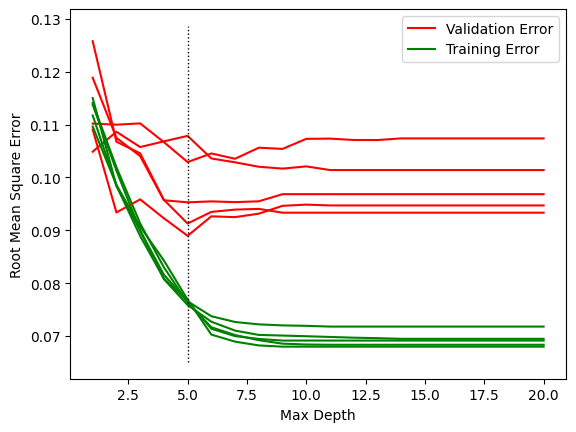

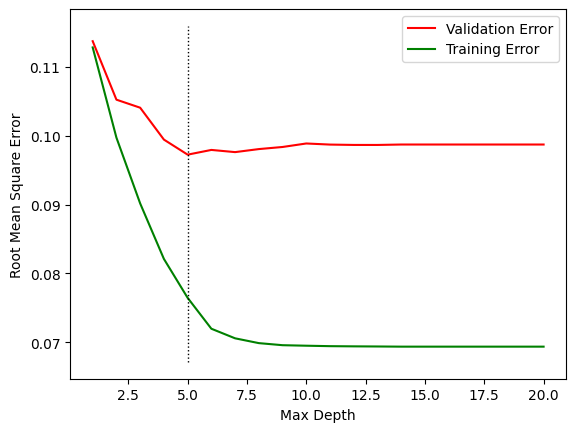

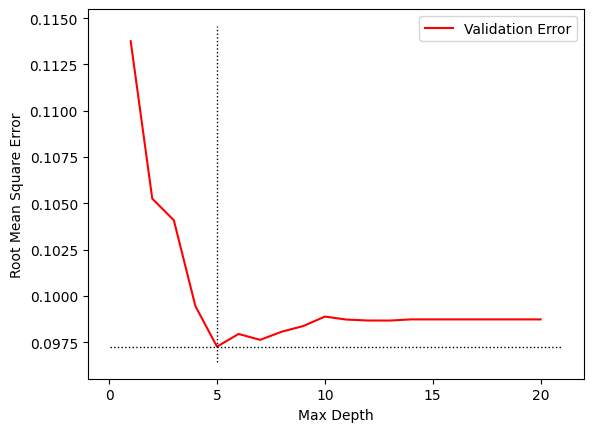

In [ ]:
Depth_Best = list(best_n(R2_Val,1).keys())[0]

print("Best Depth :",Depth_Best)
print()
print()

print("R2 Score :",best_n(R2_Val,5))
print()
print("RMSE     :",best_n(RMSE_Val,5,get_max=False))
print()

for i in range(5) : 
  plt.plot(list(RMSE_Val.keys()),[val[i] for val in list(RMSE_Val.values())],color="red")
  plt.plot(list(RMSE_Train.keys()),[val[i] for val in list(RMSE_Train.values())],color="green")
plt.legend(["Validation Error","Training Error"])
plt.ylabel("Root Mean Square Error")
plt.xlabel("Max Depth")
plt.plot([Depth_Best,Depth_Best],plt.gca().get_ylim(), linewidth=1,color="black",linestyle=':')
plt.show()

plt.plot(list(RMSE_Val.keys()),[sum(val)/5 for val in list(RMSE_Val.values())],color="red")
plt.plot(list(RMSE_Train.keys()),[sum(val)/5 for val in list(RMSE_Train.values())],color="green")
plt.legend(["Validation Error","Training Error"])
plt.ylabel("Root Mean Square Error")
plt.xlabel("Max Depth")
plt.plot([Depth_Best,Depth_Best],plt.gca().get_ylim(), linewidth=1,color="black",linestyle=':')
plt.show()

plt.plot(list(RMSE_Val.keys()),[sum(val)/5 for val in list(RMSE_Val.values())],color="red")
plt.legend(["Validation Error"])
plt.ylabel("Root Mean Square Error")
plt.xlabel("Max Depth")
plt.plot([Depth_Best,Depth_Best],plt.gca().get_ylim(), linewidth=1,color="black",linestyle=':')
RMSE_Best = sum(list(best_n(RMSE_Val,1,get_max=False).values())[0])/5
plt.plot(plt.gca().get_xlim(),[RMSE_Best,RMSE_Best], linewidth=1,color="black",linestyle=':')
plt.show()

###4) Bagging Dataset Creation

In [ ]:
n_estimators = 10
fraction = 0.7

data = []

for i in range(n_estimators) : 
  x_i = x_train.sample(frac=fraction)
  y_i = y_train[x_i.index]
  x_i.reset_index(drop=True, inplace=True)
  y_i.reset_index(drop=True, inplace=True)
  data.append((x_i,y_i))

###5) Bagging Training 

In [ ]:
Trees = []

for i in range(n_estimators) : 
  x_tr,y_tr = data[i]
  DTR = DecisionTreeRegressor(depth_max=Depth_Best,sample_split_min=20)
  DTR.train(x_tr,y_tr)   
  Trees.append(DTR)

###6) Individual Trees Performance

Tree 1 Score : 0.47456409240535236
Tree 2 Score : 0.4510940752763456
Tree 3 Score : 0.39593101483592574
Tree 4 Score : 0.5457803449188748
Tree 5 Score : 0.5004269005762585
Tree 6 Score : 0.3871978215532158
Tree 7 Score : 0.46926275452567257
Tree 8 Score : 0.5033183577307567
Tree 9 Score : 0.5126289271739901
Tree 10 Score : 0.49725632150871024



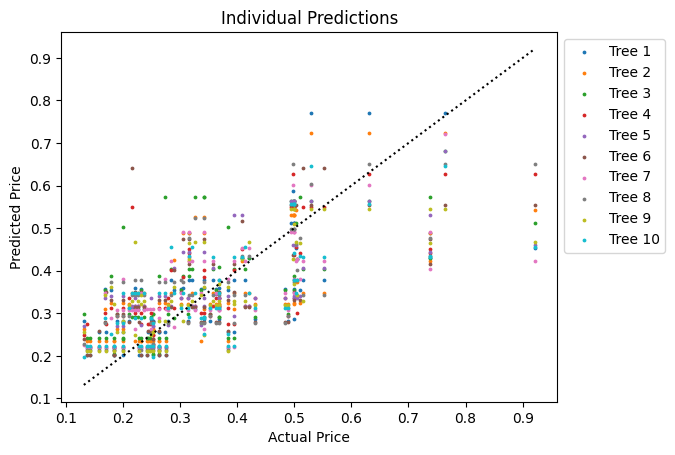


Average R Square Score : 0.4737460610505103



In [ ]:
Predictions = [None]*n_estimators
Score = [None]*n_estimators

for i in range(n_estimators) : 
  Predictions[i] = Trees[i].predict(x_test)
  Scr = R2(y_test,Predictions[i])
  Score[i] = Scr
  print(f"Tree {i+1} Score : {Scr}")

print()

for i in range(n_estimators) : 
  plt.scatter(y_test,Predictions[i],s=3)
plt.title(f"Individual Predictions")
plt.xlabel("Actual Price") 
plt.ylabel("Predicted Price")
plt.legend([f"Tree {i+1}" for i in range(n_estimators)],bbox_to_anchor=(1,1))
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],color='black',linestyle=':')
plt.show()

print()

print("Average R Square Score :", sum(Score)/n_estimators)

print()

###7) Combining Trees

Combined Trees R Square Score : 0.5666567952138539



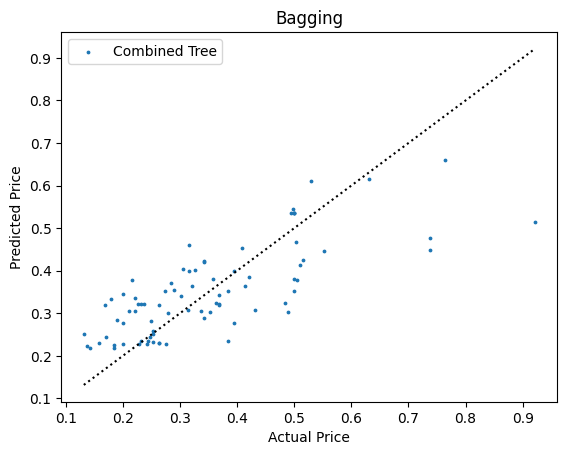


Combined Trees Score     : 0.5666567952138539
Highest Individual Score : 0.5457803449188748
Average Individual Score : 0.4737460610505103


In [ ]:
def Trees_Predict(x_test,Trees) :
  Predictions = [None]*n_estimators
  for i in range(n_estimators) : 
    Predictions[i] =  Trees[i].predict(x_test)
  #return [sum(p)/len(p) for p in zip(*Predictions)]
  return [sum([Predictions[i][j] for i in range(n_estimators)])/n_estimators for j in range(x_test.shape[0])]

Predictions = Trees_Predict(x_test,Trees)
print("Combined Trees R Square Score :", R2(y_test,Predictions))

print()

plt.scatter(y_test,Predictions,s=3)
plt.title(f"Bagging")
plt.xlabel("Actual Price") 
plt.ylabel("Predicted Price")
plt.legend(["Combined Tree"])
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],color='black',linestyle=':')
plt.show()

print()

print("Combined Trees Score     :", R2(y_test,Predictions))
print("Highest Individual Score :", max(Score))
print("Average Individual Score :", sum(Score)/n_estimators)

#### Bagging Results

In [ ]:
mse = MSE(y_test,Predictions)
mae = MAE(y_test,Predictions)
r2 = R2(y_test,Predictions)

print("Bagging -\n")
print("Mean Squared Error  :",mse)
print("Mean Absolute Error :",mae)
print("R2 Score            :",r2)

Bagging -

Mean Squared Error  : 0.010329634599033723
Mean Absolute Error : 0.0773222995387394
R2 Score            : 0.5666567952138539


###8) Changing Max Depth

In [ ]:
def bagging(max_depth=Depth_Best) : 
  Trees = []
  for i in range(n_estimators) : 
    x_tr,y_tr = data[i]
    DTR = DecisionTreeRegressor(depth_max=max_depth,sample_split_min=20)
    DTR.train(x_tr,y_tr)   
    Trees.append(DTR)
  Predictions = Trees_Predict(x_test,Trees)
  return R2(y_test,Predictions)  

def get_dephts(start,end,n) : 
  dep = []
  step = (end-start)/n
  for i in range(n) :
    d = int(start+step*(i+1))
    if(len(dep)==0 or d!=dep[-1]) : dep.append(d)
  return dep

R2_Combine = bagging()

print(f"Depth {Depth_Best} :",R2_Combine)

Depth 5 : 0.5835504837454039


####Increasing Max Depth

Depth 6 : 0.5897447450460761
Depth 7 : 0.597426348571527
Depth 8 : 0.5995614405933534
Depth 9 : 0.6009186155976992
Depth 10 : 0.6017234341454654
Depth 11 : 0.6017020126018594
Depth 12 : 0.6017626890542154
Depth 13 : 0.6017147009159352
Depth 14 : 0.6016496541899402
Depth 15 : 0.6018890888044377



Text(0, 0.5, 'R Square Score')

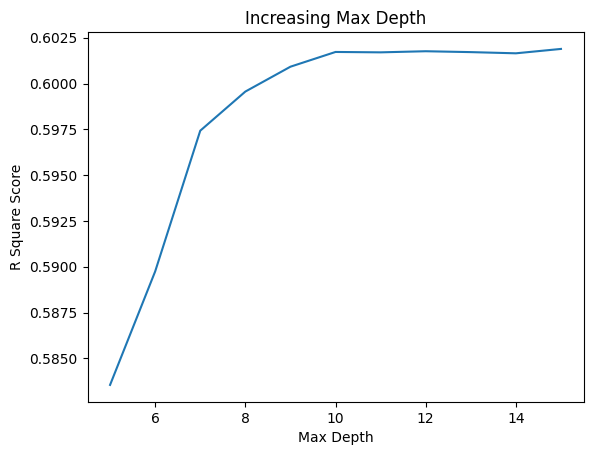

In [ ]:
score = {}
score[Depth_Best] = R2_Combine
depths = get_dephts(Depth_Best,15,10)
for dep in depths : 
  score[dep] = bagging(dep)
  print(f"Depth {dep} :",score[dep])

print()

plt.plot(list(score.keys()),list(score.values()))
plt.title("Increasing Max Depth")
plt.xlabel("Max Depth") 
plt.ylabel("R Square Score") 

####Decreasing Max Depth

Depth 1 : 0.22562317351420547
Depth 2 : 0.41283424395266344
Depth 3 : 0.522038587361028
Depth 4 : 0.5628699187352344



Text(0, 0.5, 'R Square Score')

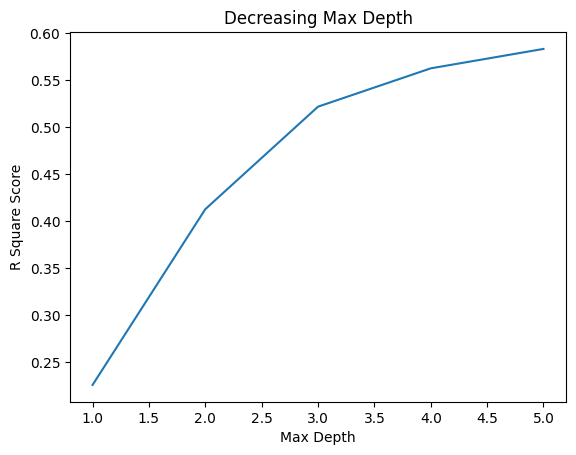

In [ ]:
score_dec = {}

depths = get_dephts(1,Depth_Best-1,10)
for dep in depths : 
  score_dec[dep] = bagging(dep)
  print(f"Depth {dep} :",score_dec[dep])

score_dec[Depth_Best] = R2_Combine
print()

plt.plot(list(score_dec.keys()),list(score_dec.values()))
plt.title("Decreasing Max Depth")
plt.xlabel("Max Depth") 
plt.ylabel("R Square Score") 

#### Depth vs R Score

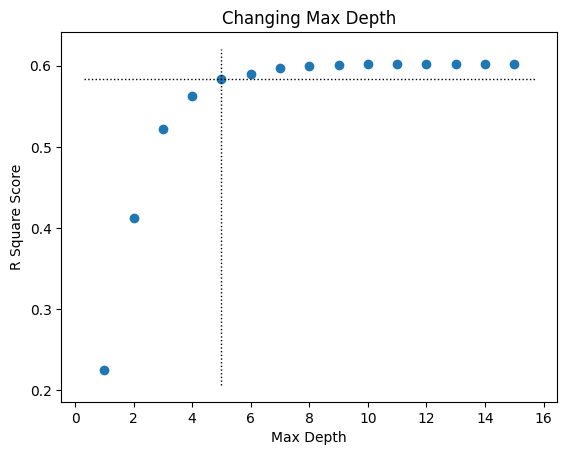

In [ ]:
score.update(score_dec)

plt.scatter(list(score.keys()),list(score.values()))
plt.title("Changing Max Depth")
plt.xlabel("Max Depth") 
plt.ylabel("R Square Score") 
plt.plot([Depth_Best,Depth_Best],plt.gca().get_ylim(), linewidth=1,color="black",linestyle=':')
plt.plot(plt.gca().get_xlim(),[R2_Combine,R2_Combine], linewidth=1,color="black",linestyle=':')
plt.show()

###9) Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor()
RFR.fit(x_train,y_train)
Predictions = RFR.predict(x_test)

mse = MSE(y_test,Predictions)
mae = MAE(y_test,Predictions)
r2 = R2(y_test,Predictions)

print("Random Forest Regressor -\n")
print("Mean Squared Error  :",mse)
print("Mean Absolute Error :",mae)
print("R2 Score            :",r2)

Random Forest Regressor -

Mean Squared Error  : 0.009659432653291243
Mean Absolute Error : 0.07149871715875052
R2 Score            : 0.5947727422241309


###10) AdaBoost Regressor


In [ ]:
from sklearn.ensemble import AdaBoostRegressor

ABR = AdaBoostRegressor()
ABR.fit(x_train,y_train)
Predictions = ABR.predict(x_test)

mse = MSE(y_test,Predictions)
mae = MAE(y_test,Predictions)
r2 = R2(y_test,Predictions)

print("AdaBoost Regressor -\n")
print("Mean Squared Error  :",mse)
print("Mean Absolute Error :",mae)
print("R2 Score            :",r2)

AdaBoost Regressor -

Mean Squared Error  : 0.011642895693652103
Mean Absolute Error : 0.08157703342156795
R2 Score            : 0.5115635810244452


##Using XGBoost & LightGBM (Inbuilt)

###1) Decision Tree Classifier (from Scratch)

####Preprocessing

In [ ]:
import pandas as pd

df = pd.read_csv(path+'Breast_cancer_data.csv')

def remove_missing(df) : 
  remove = []
  for i, row in df.iterrows():
    if row.isna().values.any() : remove.append(i)
  df.drop(remove,axis=0,inplace=True)

def remove_mismatch(df) : 
  for col in df : 
    df.reset_index(drop=True, inplace=True)
    s = [False]*len(df[col])
    for i,cell in enumerate(df[col]) : 
      try : n = int(cell)
      except : s[i] = True
    t = s.count(True)
    f = s.count(False)
    st = False
    if(t>f) : st = True
    remove = [i for i in range(len(df[col])) if s[i]!=st]
    df.drop(remove,axis=0,inplace=True)

def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

remove_missing(df)

remove_mismatch(df)

str_to_num(df)

df.head(4)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0


In [ ]:
x = df.iloc[:,:-1].copy()
y = df.iloc[:,-1].copy()

x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.85,random_state=42) 

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print("Train Data   :",x_train.shape)
print("Train Labels :",y_train.shape)
print()
print("Test Data    :",x_test.shape)
print("Test Labels  :",y_test.shape)

Train Data   : (483, 5)
Train Labels : (483,)

Test Data    : (86, 5)
Test Labels  : (86,)


#### Cost Function

In [ ]:
def find_index(elem,arr) : 
  for i,a in enumerate(arr) : 
    if(a==elem) : return i
  return -1
  

def gini_index(A,Y) :
  unique = A.unique()
  classes = Y.unique()
  n = A.shape[0]
  u = len(unique)
  c = len(classes)
  gini = 0 
  sv = [[0]*c for i in range(u)]
  for i in range(n) :
    sv[find_index(A.iloc[i],unique)][find_index(Y.iloc[i],classes)]+= 1 
  sum_all = 0
  for i in range(u) : 
    sum_row = sum(sv[i])
    sum_sqr = sum([j**2 for j in sv[i]])
    sum_all+= sum_row
    gini = gini + sum_row * (1 - sum_sqr/(sum_row**2))
  gini = gini/sum_all
  return gini

print(gini_index(x_train.iloc[:,0],y_train))

0.042097998619737745


####Continuous Data to Categorical Data Function

In [ ]:
# If number of distinct elements for an attribute > countinuous_threshold 
# Then it will be converted to binary categorical form 
countinuous_threshold = 5

def find_th(A,Y,start=0,end=1,n=11,depth=2) :

  min_A = A.min()
  max_A = A.max()

  if(depth==0) : 
    i = (start+end)/2
    th = min_A + (max_A-min_A)*i
    return th

  gini_min = 1
  i_min = 0
  step = (end-start)/(n-1)

  for i in [start+step*j for j in range(n)] : 
    A_cat = A.copy()
    th = min_A + (max_A-min_A)*i
    for j in range(A_cat.shape[0]) : 
      A_cat.iloc[j] = 0 if(A_cat.iloc[j]<th) else 1
    gini = gini_index(A_cat,Y)
    if(gini<gini_min) : 
      gini_min = gini
      i_min = i
    #print(i,gini)

  if(i_min<(start+step)) : return find_th(A,Y,start,start+step,n,depth-1)
  if(i_min>(end-step)) : return find_th(A,Y,end-step,end,n,depth-1)
  return find_th(A,Y,i_min-step,i_min+step,n,depth-1)   

def cont_to_cat(df,Y=None,th=None,iloc=None,loc=None,step=0.1,n=11,depth=2) :

  if iloc is None : 
    if loc is None : return
    iloc = df.columns.get_loc(loc)
  A = df.iloc[:,iloc]


  if(step>=0.5) : n = 4
  elif(step<=0) : n = 11
  elif(n==11) : n = 1+int(1/step)
  if(n<=3) : n = 4

  if th is None : th = find_th(A,Y,n=n,depth=depth)

  for j in range(df.shape[0]) : 
    df.iloc[j,iloc] = 0 if(df.iloc[j,iloc]<th) else 1
  df.iloc[:,iloc] = df.iloc[:,iloc].astype(int)
  return th

def cont_to_cat_all(X,Y,step=0.1,n=11,depth=2) : 
  global countinuous_threshold
  th = {}
  for col in X : 
    if(len(X[col].unique())>countinuous_threshold) : 
      col_i = X.columns.get_loc(col)
      th[col] = cont_to_cat(X,Y=Y,iloc=col_i,step=step,n=n,depth=depth)
  return th

def find_th_all(X,Y,step=0.1,n=11,depth=2) : 
  global countinuous_threshold
  th = {}
  for col in X : 
    if(len(X[col].unique())>countinuous_threshold) : 
      col_i = X.columns.get_loc(col)
      th[col] = find_th(X.iloc[:,col_i],Y,n=n,depth=depth)
  return th

def visualize_th(th,iloc) : 
  sb.kdeplot(x =x_train.columns[iloc], hue=y_train.name, data = df, color = 'black').set_title(f'Threshold for {x_train.columns[iloc]}')
  plt.plot([th,th],plt.gca().get_ylim(), linewidth=2,color="black")

cont_to_cat_th = find_th_all(x_train,y_train)

for atr in cont_to_cat_th.keys() : 
  print(f"Threshold for {atr} : {cont_to_cat_th[atr]}")

x_train.head()

Threshold for mean_radius : 15.04184
Threshold for mean_texture : 19.172400000000003
Threshold for mean_perimeter : 98.52879999999999
Threshold for mean_area : 683.1320000000001
Threshold for mean_smoothness : 0.0902918


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
0,12.46,24.04,83.97,475.9,0.11860
1,17.60,23.33,119.00,980.5,0.09289
2,12.05,22.72,78.75,447.8,0.06935
3,12.86,13.32,82.82,504.8,0.11340
4,12.00,15.65,76.95,443.3,0.09723


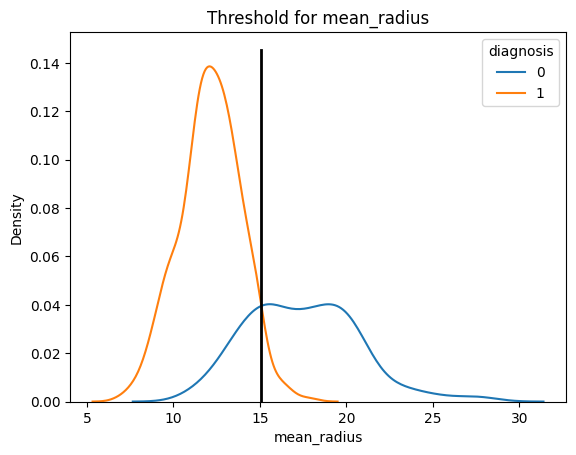

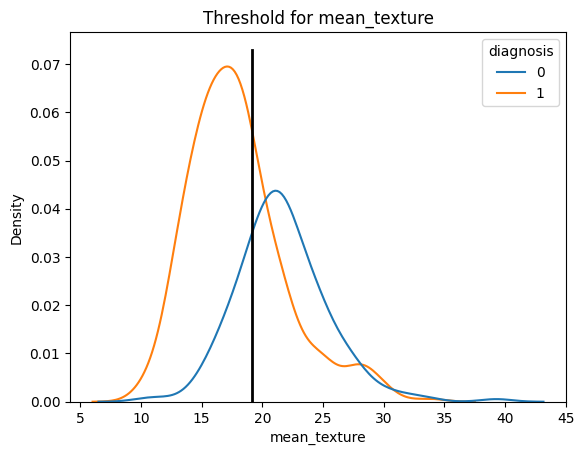

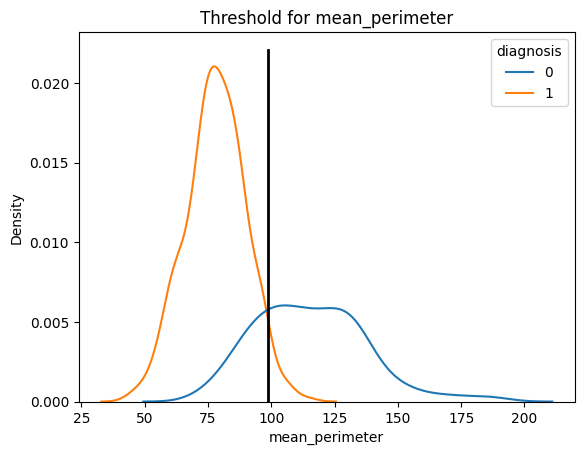

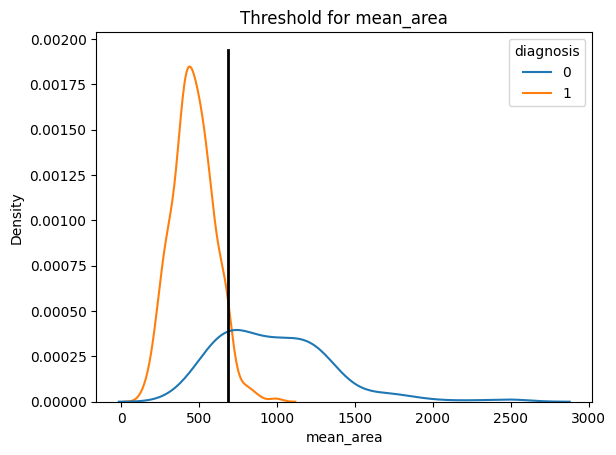

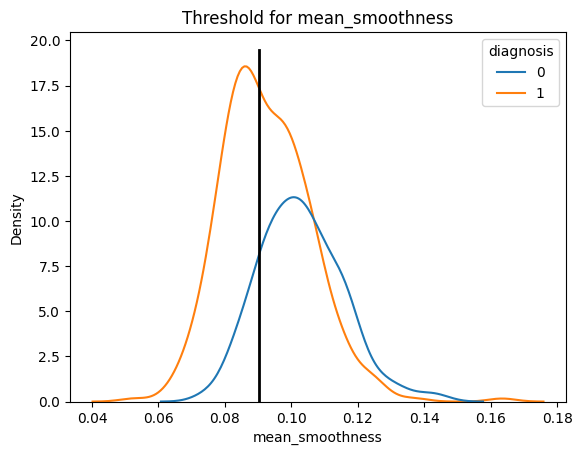

In [ ]:
import seaborn as sb
from matplotlib import pyplot as plt

for atr in cont_to_cat_th.keys() : 
  visualize_th(cont_to_cat_th[atr],x_train.columns.get_loc(atr))
  plt.show()

####Decison Tree Classifier

In [ ]:
class Node : 

  def __init__(self,dep=-1) : 
    self.child = {}
    self.A = None
    self.Y = None
    self.leaf = False
    self.depth = dep+1


class DecisionTree : 

  def __init__(self,depth_max=None,gain_min=0) :
    self.root = Node()
    self.cont_to_cat_th = {}
    self.depth_max = depth_max
    self.gain_min = gain_min


  def get_best_split(self,X,Y) : 
    gini_min = 1 
    col_min = None
    for col in X:
      gini = gini_index(X[col],Y)
      if(gini<gini_min) : 
        gini_min = gini
        col_min = col
    return col_min,gini_min


  def split(self,node,A) :
    node.A = A.name
    for val in A.unique() : 
      node.child[val] = Node(node.depth) 


  def info_gain(self,gini_A,Y) : 
    n = Y.shape[0]
    sum_sqr = sum([j**2 for j in Y.value_counts()])
    gini = 1 - sum_sqr/(n**2)
    gain = gini - gini_A
    return gain

    
  def grow(self,node,X,Y,depth_max,gain_min) : 

    node.Y = Y.mode().iloc[0]
    
    if (node.depth == depth_max) :
      node.leaf = True
      return
    if(len(X.columns)==0) : 
      node.leaf = True
      return  

    A_best,gini_A = self.get_best_split(X,Y) 

    if(self.info_gain(gini_A,Y)<gain_min) : 
      node.leaf = True
      return
    
    self.split(node,X[A_best])

    children = node.child.keys()
    ind_mat = [[] for i in range(len(children))]
    for i,x in X[A_best].iteritems() :
      ind_mat[find_index(x,children)].append(i)

    for i,child in enumerate(children) : 
      x = X.iloc[ind_mat[i]].copy()
      x.drop(A_best,axis=1,inplace=True)
      x.reset_index(drop=True, inplace=True)
      y = Y.iloc[ind_mat[i]].copy()
      y.reset_index(drop=True, inplace=True)

      self.grow(node.child[child],x,y,depth_max,gain_min)


  def train(self,X,Y) :
    Xt = X.copy()
    Yt = Y.copy()
    self.cont_to_cat_th = cont_to_cat_all(Xt,Yt)
    self.grow(self.root,Xt,Yt,self.depth_max,self.gain_min) 


  def travel(self,node,x) : 
    if(node.leaf) : return node.Y
    if(x.loc[node.A] not in node.child.keys()) : return node.Y
    return self.travel(node.child[x.loc[node.A]],x)


  def predict(self,X) : 
    Xp = X.copy() 
    for atr in self.cont_to_cat_th.keys() :
      cont_to_cat(Xp,th=self.cont_to_cat_th[atr],loc=atr)
    predictions = [-1]*(Xp.shape[0])
    for i,x in Xp.iterrows() :
      predictions[i] = self.travel(self.root,x)
    return predictions


  def print_node(self,node) : 
    print("Prediction Here :",node.Y)
    if(node.leaf) : 
      print("LEAF NODE")
      return
    print("Check for next node :",node.A)
    print()
    for val in node.child.keys() : 
      print("Entering",node.A, val)
      print()
      self.print_node(node.child[val])
      print()
      print("Exiting",node.A,val)
      print()


  def print_tree(self) : 
    self.print_node(self.root)

####Training & Predicting

In [ ]:
DT = DecisionTree(depth_max=3,gain_min=0.05)
DT.train(x_train,y_train) 

Predictions = DT.predict(x_test)

Predictions = list(Predictions)

print("Prediction :",Predictions)
print("Actual     :",list(y_test))

Prediction : [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]
Actual     : [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0]


####Accuracy

In [ ]:
def average(actual,prediction):
  actual = list(actual)
  prediction = list(prediction)
  acc = 0 
  for i in range(len(actual)) : 
    acc+= int(actual[i]==prediction[i])
  acc = acc/len(actual)
  return int(100*round(acc,2)) 

print("Overall Accuracy:",average(y_test,Predictions),"%")

print()

def class_wise_average(actual,prediction):
  actual = list(actual)
  prediction = list(prediction)
  acc = {}
  n = {}
  for i in range(len(actual)) : 
    c = actual[i]
    if c in acc.keys() : 
      acc[c] = acc[c] + int(actual[i]==prediction[i])
      n[c] = n[c] + 1
    else : 
      acc[c] = int(actual[i]==prediction[i])
      n[c] = 1
  for i in acc.keys() : 
    acc[i] = int(round(acc[i]/n[i],3)*100)
  return acc

def print_cw(cw,label=None) : 
  try : 
    stl = max([len(st) for st in label])
  except : 
    stl = max([len(str(i)) for i in cw.keys()]) 
  for i in cw.keys() : 
    try : 
      s = label[i]
    except : s = str(i)
    print(f"\t\t{s}{' '*(stl-len(s))} : {cw[i]} %")
  print()

print("Class-Wise Accurcy :")
print_cw(class_wise_average(y_test,Predictions),["Cancer Absent","Cancer Present"])

Overall Accuracy: 93 %

Class-Wise Accurcy :
		Cancer Present : 100 %
		Cancer Absent  : 81 %



###2) 5-Cross Validation

In [ ]:
def split_5(x,y) : 
  data = [dict.fromkeys(['x','y']) for i in range(5)]
  data[0]['x'] = x.copy()
  data[0]['y'] = y.copy() 
  for i in range(4) : 
    size = 1/(5-i)
    data[i]['x'],data[i+1]['x'],data[i]['y'],data[i+1]['y'] = train_test_split(data[i]['x'],data[i]['y'],train_size=size,random_state=42)
  return data

data = split_5(x_train,y_train)

for i in range(5) : 
  data[i]['x'].reset_index(drop=True, inplace=True)
  data[i]['y'].reset_index(drop=True, inplace=True)
  print(f"Group {i+1} X :",data[i]['x'].shape)
  print(f"Group {i+1} Y :",data[i]['y'].shape)

Group 1 X : (96, 5)
Group 1 Y : (96,)
Group 2 X : (96, 5)
Group 2 Y : (96,)
Group 3 X : (97, 5)
Group 3 Y : (97,)
Group 4 X : (97, 5)
Group 4 Y : (97,)
Group 5 X : (97, 5)
Group 5 Y : (97,)


In [ ]:
Depth_Start = 0
Depth_End = 10

depths = list(range(Depth_Start,Depth_End+1))

Acc_Val = {}
Acc_Train = {}
C0 = {}
C1 = {}

for dep in depths : 
  for i in range(5) : 
    Acc_Val[dep] = []
    Acc_Train[dep] = []
    C0[dep] = []
    C1[dep] = []

for i in range(5) : 

  print(f"Fold {i+1}",end=" |") 

  x_tr = pd.concat([data[j]['x'].copy() for j in range(5) if j!=i],ignore_index=True)
  y_tr = pd.concat([data[j]['y'].copy() for j in range(5) if j!=i],ignore_index=True)
  x_vl = data[i]['x'].copy()
  y_vl = data[i]['y'].copy() 

  x_tr.reset_index(drop=True, inplace=True)
  y_tr.reset_index(drop=True, inplace=True)
  x_vl.reset_index(drop=True, inplace=True)
  x_vl.reset_index(drop=True, inplace=True)

  for dep in depths : 
    print("=",end="")
    DT = DecisionTree(depth_max=dep)
    DT.train(x_tr,y_tr)   
    Predictions = DT.predict(x_vl)
    acc = average(y_vl,Predictions)
    Acc_Val[dep].append(acc)
    cw = class_wise_average(y_vl,Predictions)
    C0[dep].append(cw[0])
    C1[dep].append(cw[1])
    Predictions = DT.predict(x_tr)
    acc = average(y_tr,Predictions)
    Acc_Train[dep].append(acc)
  
  print("|")

print()

def best_n(dct,n=3,get_max=True) :
  new = {}
  d = dct.copy()
  for j in range(n) :
    i_best = None
    for i in d.keys() :  
      if(i_best is None or (bool(sum(d[i])>sum(d[i_best]))==bool(get_max))) : 
        i_best = i
    new[i_best] = d[i_best]
    del d[i_best]
  return new

print("DONE")

print()
Depth_Best = list(best_n(Acc_Val,1).keys())[0]
print("Best Depth :",Depth_Best)

Fold 1 |===========|
Fold 2 |===========|
Fold 3 |===========|
Fold 4 |===========|
Fold 5 |===========|

DONE

Best Depth : 1


###3) Visualization of Cross Validation

Best Depth : 1


Average Accuracy : {1: [85, 89, 89, 82, 96], 2: [85, 89, 89, 82, 96], 4: [86, 91, 90, 84, 85], 5: [86, 91, 90, 84, 85], 6: [86, 91, 90, 84, 85]}

Cancer Present Accuracy : {0: [100, 100, 100, 100, 100], 1: [94, 100, 97, 93, 98], 2: [94, 100, 97, 93, 98], 4: [94, 100, 97, 93, 81], 5: [94, 100, 97, 93, 81]}

Cancer Absent Accuracy  : {4: [76, 73, 73, 69, 91], 5: [76, 73, 73, 69, 91], 6: [76, 73, 73, 69, 91], 7: [76, 73, 73, 69, 91], 8: [76, 73, 73, 69, 91]}



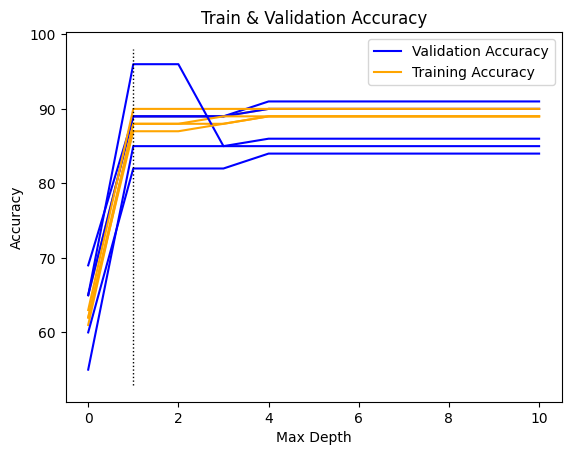

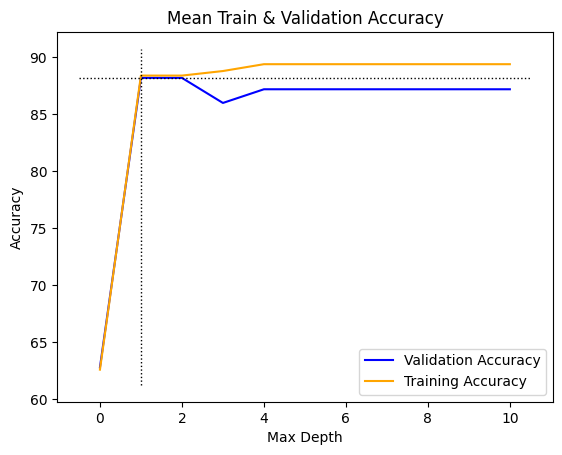

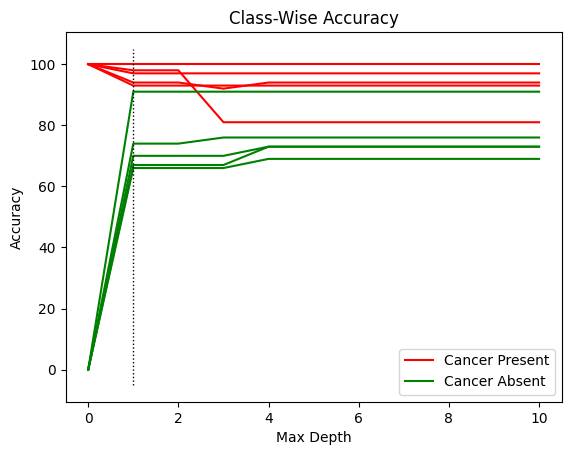

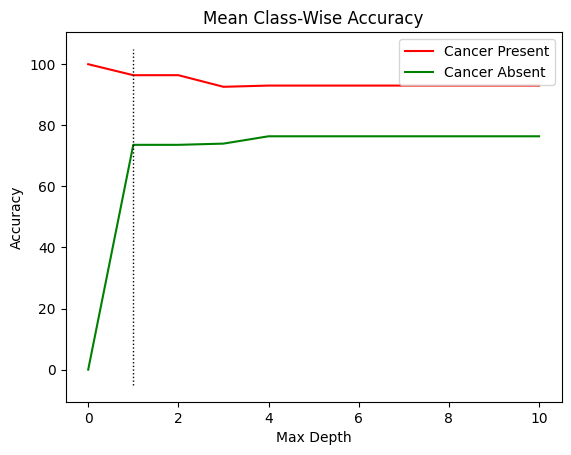

In [ ]:
Depth_Best = list(best_n(Acc_Val,1).keys())[0]

print("Best Depth :",Depth_Best)
print()
print()

print("Average Accuracy :",best_n(Acc_Val,5))
print()
print("Cancer Present Accuracy :",best_n(C1,5))
print()
print("Cancer Absent Accuracy  :",best_n(C0,5))
print()

plt.style.use('default')

for i in range(5) : 
  plt.plot(list(Acc_Val.keys()),[val[i] for val in list(Acc_Val.values())],color="blue")
  plt.plot(list(Acc_Train.keys()),[val[i] for val in list(Acc_Train.values())],color="orange")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title("Train & Validation Accuracy")
plt.legend(["Validation Accuracy","Training Accuracy"])
plt.plot([Depth_Best,Depth_Best],plt.gca().get_ylim(), linewidth=1,color="black",linestyle=':')
plt.show()

Acc_Best = sum(list(best_n(Acc_Val,1).values())[0])/5

plt.plot(list(Acc_Val.keys()),[sum(val)/5 for val in list(Acc_Val.values())],color="blue")
plt.plot(list(Acc_Train.keys()),[sum(val)/5 for val in list(Acc_Train.values())],color="orange")
plt.legend(["Validation Accuracy","Training Accuracy"])
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title("Mean Train & Validation Accuracy")
plt.plot([Depth_Best,Depth_Best],plt.gca().get_ylim(), linewidth=1,color="black",linestyle=':')
plt.plot(plt.gca().get_xlim(),[Acc_Best,Acc_Best], linewidth=1,color="black",linestyle=':')
plt.show()

for i in range(5) : 
  plt.plot(list(C1.keys()),[val[i] for val in list(C1.values())],color="red")
  plt.plot(list(C0.keys()),[val[i] for val in list(C0.values())],color="green")
plt.legend(["Cancer Present","Cancer Absent"])
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title("Class-Wise Accuracy")
plt.plot([Depth_Best,Depth_Best],plt.gca().get_ylim(), linewidth=1,color="black",linestyle=':')
plt.show()

plt.plot(list(C1.keys()),[sum(val)/5 for val in list(C1.values())],color="red")
plt.plot(list(C0.keys()),[sum(val)/5 for val in list(C0.values())],color="green")
plt.legend(["Cancer Present","Cancer Absent"])
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title("Mean Class-Wise Accuracy")
plt.plot([Depth_Best,Depth_Best],plt.gca().get_ylim(), linewidth=1,color="black",linestyle=':')
plt.show()

###4) XGBoost 

In [ ]:
!pip install xgboost

import xgboost as xgb

dtrain = xgb.DMatrix(x_train,y_train)
dtest = xgb.DMatrix(x_test,y_test)

param = {}
param['max_depth'] = 4
param['subsample'] = 0.7
param['objective'] = 'multi:softmax'
param['num_class'] = 2

DT = xgb.train(param, dtrain)

Predictions_Train = DT.predict(dtrain)
Predictions_Test = DT.predict(dtest)

###5) XGBoost Accuracy

In [ ]:
print("TRAIN DATA -\n")

print("Overall Accuracy:",average(y_train,Predictions_Train),"%")

print()

print("Class-Wise Accurcy :")
print_cw(class_wise_average(y_train,Predictions_Train),["Cancer Absent","Cancer Present"])

print()

print("TEST DATA -\n")

print("Overall Accuracy:",average(y_test,Predictions_Test),"%")

print()

print("Class-Wise Accurcy :")
print_cw(class_wise_average(y_test,Predictions_Test),["Cancer Absent","Cancer Present"])

TRAIN DATA -

Overall Accuracy: 96 %

Class-Wise Accurcy :
		Cancer Absent  : 93 %
		Cancer Present : 97 %


TEST DATA -

Overall Accuracy: 95 %

Class-Wise Accurcy :
		Cancer Present : 98 %
		Cancer Absent  : 90 %



###6) LightGBM



In [ ]:
!pip install lightgbm

import lightgbm as lgb

Trees = {}

dep_max = 3

for leaves in range(2,1+2**dep_max) : 

  DT = lgb.LGBMClassifier(max_depth=dep_max, num_leaves=leaves)
  DT.fit(x_train,y_train)
  Trees[leaves] = DT

In [ ]:
Acc_Test = {}
Acc_Train = {}
C0 = {}
C1 = {}

for leaves in Trees.keys() :
  Predictions_Train = Trees[leaves].predict(x_train)
  Predictions_Test = Trees[leaves].predict(x_test)
  Acc_Test[leaves] = average(y_test,Predictions_Test)
  Acc_Train[leaves] = average(y_train,Predictions_Train)
  cw = class_wise_average(y_test,Predictions_Test)
  C0[leaves] = cw[0]
  C1[leaves] = cw[1]

Average Accuracy : {2: 97, 8: 97, 4: 95, 7: 95, 5: 94}

Cancer Present Accuracy : {2: 100, 4: 96, 5: 96, 6: 96, 7: 96}

Cancer Absent Accuracy  : {8: 96, 4: 93, 7: 93, 2: 90, 3: 90}



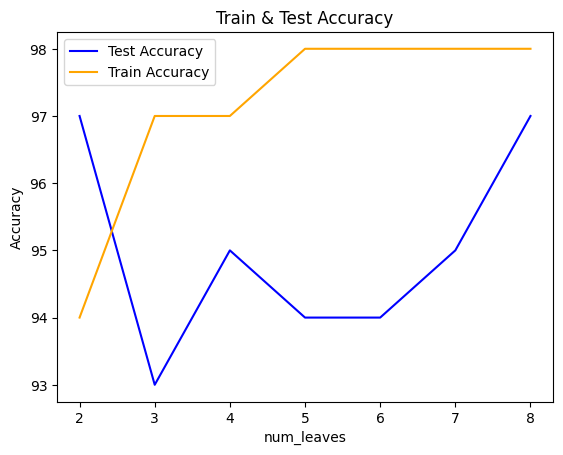

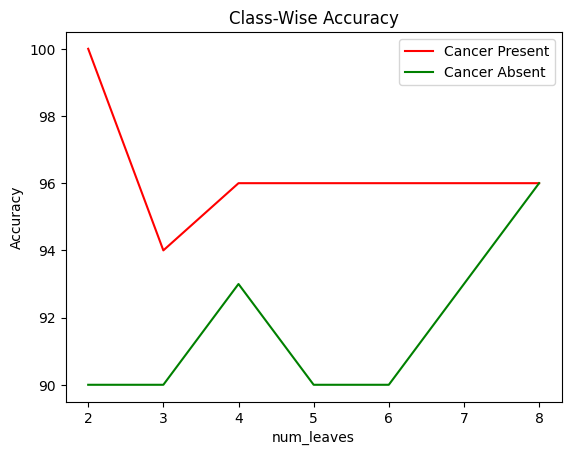

In [ ]:
def best_n(dct,n=3,get_max=True) :
  new = {}
  d = dct.copy()
  for j in range(n) :
    i_best = None
    for i in d.keys() :  
      if(i_best is None or (bool(d[i]>d[i_best])==bool(get_max))) : 
        i_best = i
    new[i_best] = d[i_best]
    del d[i_best]
  return new

print("Average Accuracy :",best_n(Acc_Test,5))
print()
print("Cancer Present Accuracy :",best_n(C1,5))
print()
print("Cancer Absent Accuracy  :",best_n(C0,5))
print()

plt.style.use('default')

plt.plot(list(Acc_Test.keys()),list(Acc_Test.values()),color="blue")
plt.plot(list(Acc_Train.keys()),list(Acc_Train.values()),color="orange")
plt.legend(["Test Accuracy","Train Accuracy"])
plt.ylabel("Accuracy")
plt.xlabel("num_leaves")
plt.title("Train & Test Accuracy")
plt.show()


plt.plot(list(C1.keys()),list(C1.values()),color="red")
plt.plot(list(C0.keys()),list(C0.values()),color="green")
plt.legend(["Cancer Present","Cancer Absent"])
plt.ylabel("Accuracy")
plt.xlabel("num_leaves")
plt.title("Class-Wise Accuracy")
plt.show()

###7) Relation between max_depth and num_leaves,


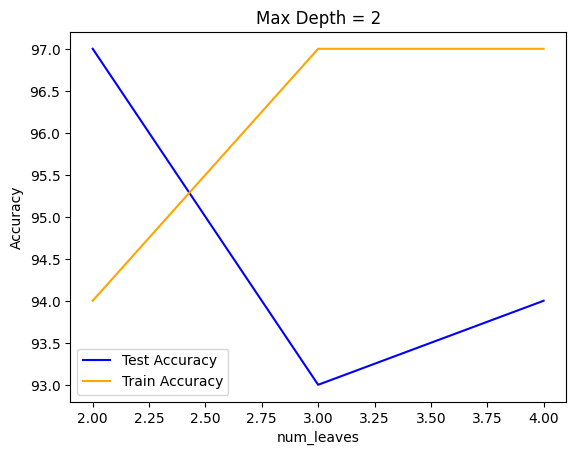

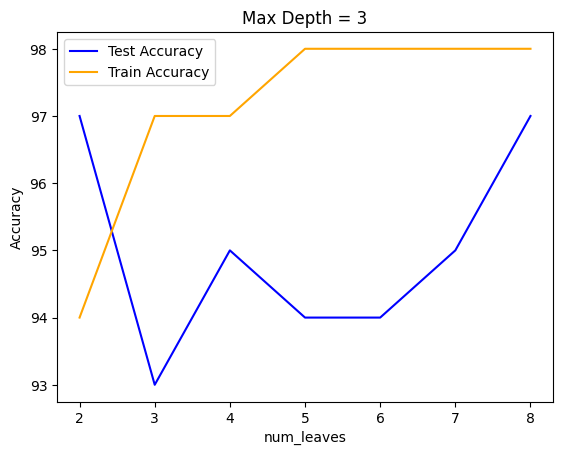

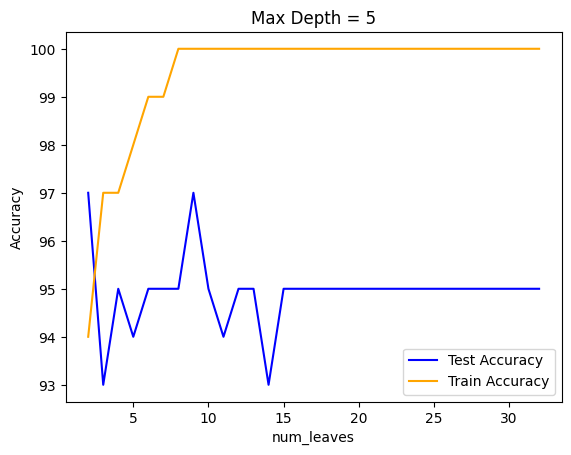

In [ ]:
for dep_max in [2,3,5] : 

  Trees = {}

  for leaves in range(2,1+2**dep_max) : 

    DT = lgb.LGBMClassifier(max_depth=dep_max, num_leaves=leaves)
    DT.fit(x_train,y_train)
    Trees[leaves] = DT

  Acc_Test = {}
  Acc_Train = {}

  for leaves in Trees.keys() :
    Predictions_Train = Trees[leaves].predict(x_train)
    Predictions_Test = Trees[leaves].predict(x_test)
    Acc_Test[leaves] = average(y_test,Predictions_Test)
    Acc_Train[leaves] = average(y_train,Predictions_Train)

  plt.plot(list(Acc_Test.keys()),list(Acc_Test.values()),color="blue")
  plt.plot(list(Acc_Train.keys()),list(Acc_Train.values()),color="orange")
  plt.legend(["Test Accuracy","Train Accuracy"])
  plt.ylabel("Accuracy")
  plt.xlabel("num_leaves")
  plt.title(f"Max Depth = {dep_max}")

  plt.show()

###8) Best Parameters
 

####Better Accuracy

In [ ]:
n = 3

def best_n(d,n=3) :
  new = {}
  for j in range(n) :
    i_min = None
    for i in d.keys() :  
      if(i_min is None or d[i]>d[i_min]) : 
        i_min = i
    new[i_min] = d[i_min]
    del d[i_min]
  return new


def find_num_leaves() : 

  global x_train,x_test,y_train,y_test,n

  md = {}

  for i in range(2,12) : 

    DT = lgb.LGBMClassifier(num_leaves=i)

    DT.fit(x_train,y_train)

    Predictions = DT.predict(x_test)

    avg = average(y_test,Predictions)

    md[(i)] = avg

  return best_n(md,n)


def find_num_iterations(params,start=10,end=1000,points=8,depth=3) : 

  global x_train,x_test,y_train,y_test,n

  mi = {}

  mse_min = None
  i_min = 0
  step = (end-start)/(points-1)

  for i in [start+step*j for j in range(n)] :  

    i = int(i)

    for md in params : 

      DT = lgb.LGBMClassifier(num_leaves=md, num_iterations=i)

      DT.fit(x_train,y_train)

      Predictions = DT.predict(x_test)

      avg = average(y_test,Predictions)

      mse = avg
      if(depth==1) : mi[(md,i)] = avg

      if mse_min is None or mse<mse_min :
        mse_min = mse
        i_min = i
  
  st = i_min - step
  ed = i_min + step
  if(st<start) : st = start
  if(ed>end) : ed = end

  if(depth==1) : return best_n(mi,n)

  return find_num_iterations(params,st,ed,points,depth-1)


def find_lr(params,start=0,end=1,points=10,depth=3) : 

  global x_train,x_test,y_train,y_test,n

  ca = {}

  for i in range(1,8):  

    for md,mi in params : 

      DT = lgb.LGBMClassifier(num_leaves=md, num_iterations=mi, max_depth=i)

      DT.fit(x_train,y_train)

      Predictions = DT.predict(x_test)

      ca[(md,mi,i)] = average(y_test,Predictions)

  return best_n(ca,n)


md = find_num_leaves()
mi = find_num_iterations(md.keys())

print("Accuracy :")
for i in md : 
  print(f"num_leaves = {i}  :",md[i])
print()

print("Accuracy :")
for i in mi : 
  print(f"num_leaves = {i[0]} | num_iterations = {i[1]}  :",mi[i])
print()

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n

Accuracy :
num_leaves = 2  : 97
num_leaves = 4  : 95
num_leaves = 6  : 95

Accuracy :
num_leaves = 4 | num_iterations = 15  : 97
num_leaves = 4 | num_iterations = 10  : 95
num_leaves = 4 | num_iterations = 12  : 95



/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n

####Least Overfitting

In [ ]:
n = 3

def best_n(d,n=3) :
  new = {}
  for j in range(n) :
    i_min = None
    for i in d.keys() :  
      if(i_min is None or d[i]>d[i_min]) : 
        i_min = i
    new[i_min] = d[i_min]
    del d[i_min]
  return new


def find_num_leaves() : 

  global x_train,x_test,y_train,y_test,n

  x_t1,x_t2,y_t1,y_t2 = train_test_split(x_train,y_train,train_size=0.5)

  md = {}

  for i in range(2,12) : 

    DT = lgb.LGBMClassifier(num_leaves=i)

    DT.fit(x_t1,y_t1)

    Predictions1 = DT.predict(x_test)

    DT = lgb.LGBMClassifier(num_leaves=i)

    DT.fit(x_t2,y_t2)

    Predictions2 = DT.predict(x_test)

    md[(i)] = average(Predictions1,Predictions2)

  return best_n(md,n)


def find_num_iterations(params,start=10,end=1000,points=8,depth=3) : 

  global x_train,x_test,y_train,y_test,n

  x_t1,x_t2,y_t1,y_t2 = train_test_split(x_train,y_train,train_size=0.5)

  mi = {}

  mse_min = None
  i_min = 0
  step = (end-start)/(points-1)

  for i in [start+step*j for j in range(n)] :  

    i = int(i)
    
    for md in params : 

      DT = lgb.LGBMClassifier(num_leaves=md,num_iterations=i)

      DT.fit(x_t1,y_t1)

      Predictions1 = DT.predict(x_test)

      DT = lgb.LGBMClassifier(num_leaves=md,num_iterations=i)

      DT.fit(x_t2,y_t2)

      Predictions2 = DT.predict(x_test)

      mse = average(Predictions1,Predictions2)
      if(depth==1) : mi[(md,i)] = average(Predictions1,Predictions2)

      if mse_min is None or mse<mse_min :
        mse_min = mse
        i_min = i
  
  st = i_min - step
  ed = i_min + step
  if(st<start) : st = start
  if(ed>end) : ed = end


  if(depth==1) : return best_n(mi,n)

  return find_num_iterations(params,st,ed,points,depth-1)


md = find_num_leaves()
mi = find_num_iterations(md.keys())

print("Accuracy :")
for i in md : 
  print(f"num_leaves = {i}  :",md[i])
print()

print("Accuracy :")
for i in mi : 
  print(f"num_leaves = {i[0]} | num_iterations = {i[1]}  :",mi[i])
print()

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n

Accuracy :
num_leaves = 2  : 97
num_leaves = 4  : 93
num_leaves = 5  : 93

Accuracy :
num_leaves = 2 | num_iterations = 150  : 95
num_leaves = 2 | num_iterations = 156  : 95
num_leaves = 2 | num_iterations = 161  : 95



/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
